[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/state-schema.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239426-lesson-1-state-schema)

# State Schema(상태 스키마)

## 복습

모듈 1에서는 기초를 다졌습니다! 우리는 다음과 같은 기능을 가진 에이전트를 구축했습니다:

* `act` - 모델이 특정 도구를 호출할 수 있도록 합니다
* `observe` - 도구 출력을 모델로 다시 전달합니다
* `reason` - 모델이 도구 출력에 대해 추론하여 다음 행동(예: 다른 도구 호출 또는 직접 응답)을 결정할 수 있도록 합니다
* `persist state` - 중단이 발생해도 장기 대화 지원을 위한 메모리 내 체크포인트 사용
 
또한 LangGraph Studio에서 로컬로 실행하거나 LangGraph Cloud로 배포하는 방법을 살펴보았습니다.

## 목표

이번 모듈에서는 상태와 메모리에 대한 이해를 심화할 것입니다.

먼저 상태 스키마를 정의하는 다양한 방법을 복습해 보겠습니다.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph

## Schema(스키마)

LangGraph `StateGraph`를 정의할 때 우리는 [state schema](https://langchain-ai.github.io/langgraph/concepts/low_level/#state)를 사용합니다.

상태 스키마는 그래프가 사용할 데이터의 구조와 유형을 나타냅니다.

모든 노드는 해당 스키마와 통신해야 합니다.

LangGraph는 상태 스키마 정의 방식에 유연성을 제공하여 다양한 Python [타입](https://docs.python.org/3/library/stdtypes.html#type-objects)과 검증 방식을 수용합니다!

## TypedDict

모듈 1에서 언급했듯이, Python의 `typing` 모듈에서 제공하는 `TypedDict` 클래스를 사용할 수 있습니다.

이를 통해 키와 해당 값의 유형을 지정할 수 있습니다.
 
하지만 이는 타입 힌트에 불과하다는 점을 유의하세요.

정적 타입 검사기(예: [mypy](https://github.com/python/mypy))나 IDE에서 코드 실행 전에 잠재적인 타입 관련 오류를 잡아내는 데 사용할 수 있습니다.

그러나 런타임에는 강제 적용되지 않습니다!

In [ ]:
from typing import TypedDict


class TypedDictState(TypedDict):
    foo: str
    bar: str

더 구체적인 값 제약 조건을 위해 `Literal` 타입 힌트 등을 사용할 수 있습니다.

여기서 `mood`는 "happy" 또는 "sad" 중 하나만 가질 수 있습니다.

In [ ]:
from typing import Literal


class TypedDictState(TypedDict):
    name: str
    mood: Literal["happy", "sad"]

정의된 상태 클래스(예: 여기서는 `TypedDictState`)를 LangGraph에서 사용하려면 단순히 `StateGraph`에 전달하기만 하면 됩니다.

또한 각 상태 키를 그래프 내의 단순한 "채널"로 생각할 수 있습니다.

모듈 1에서 논의한 바와 같이, 각 노드에서 지정된 키 또는 "채널"의 값을 덮어씁니다.

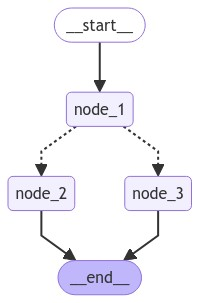

In [ ]:
import random
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END


def node_1(state):
    print("---Node 1---")
    return {"name": state["name"] + " is ... "}


def node_2(state):
    print("---Node 2---")
    return {"mood": "happy"}


def node_3(state):
    print("---Node 3---")
    return {"mood": "sad"}


def decide_mood(state) -> Literal["node_2", "node_3"]:
    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:
        # 50% of the time, we return Node 2
        return "node_2"

    # 50% of the time, we return Node 3
    return "node_3"


# Build graph
builder = StateGraph(TypedDictState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

우리 상태가 딕셔너리이므로, 단순히 딕셔너리로 그래프를 호출하여 상태 내 `name` 키의 초기값을 설정합니다.

In [ ]:
graph.invoke({"name": "Lance"})

---Node 1---
---Node 2---


{'name': 'Lance is ... ', 'mood': 'happy'}

## Dataclass

파이썬의 [dataclasses](https://docs.python.org/3/library/dataclasses.html)는 [구조화된 데이터를 정의하는 또 다른 방법](https://www.datacamp.com/tutorial/python-data-classes)을 제공합니다.

데이터 클래스는 주로 데이터를 저장하는 데 사용되는 클래스를 생성하기 위한 간결한 구문을 제공합니다.

In [ ]:
from dataclasses import dataclass


@dataclass
class DataclassState:
    name: str
    mood: Literal["happy", "sad"]

`dataclass`의 키에 접근하려면 `node_1`에서 사용된 인덱싱 방식을 수정하기만 하면 됩니다:

* 위의 `TypedDict`에서 `state["name"]` 대신 `dataclass` 상태에 대해 `state.name`을 사용합니다

약간 이상한 점이 눈에 띌 것입니다: 각 노드에서 상태 업데이트를 수행하기 위해 여전히 사전(dictionary)을 반환합니다.
 
LangGraph가 상태 객체의 각 키를 별도로 저장하기 때문에 가능합니다.

노드가 반환하는 객체는 상태 객체와 일치하는 키(속성)만 있으면 됩니다!

이 경우 `dataclass`에는 `name` 키가 있으므로, 상태가 `TypedDict`였을 때와 마찬가지로 노드에서 딕셔너리를 전달하여 업데이트할 수 있습니다.

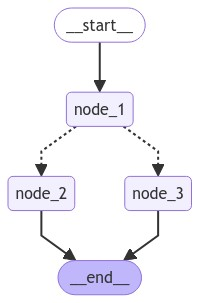

In [ ]:
def node_1(state):
    print("---Node 1---")
    return {"name": state.name + " is ... "}


# Build graph
builder = StateGraph(DataclassState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

우리는 `dataclass`를 호출하여 상태의 각 키/채널에 대한 초기값을 설정합니다!

In [ ]:
graph.invoke(DataclassState(name="Lance", mood="sad"))

---Node 1---
---Node 3---


{'name': 'Lance is ... ', 'mood': 'sad'}

## Pydantic

앞서 언급했듯이 `TypedDict`와 `dataclasses`는 타입 힌트를 제공하지만 런타임에 타입을 강제하지 않습니다.

이는 오류 발생 없이 잠재적으로 잘못된 값을 할당할 수 있음을 의미합니다!

예를 들어, 타입 힌트가 `mood: list[Literal["happy","sad"]]`로 지정되어 있음에도 `mood`를 `mad`로 설정할 수 있습니다.

In [8]:
dataclass_instance = DataclassState(name="Lance", mood="mad")

[Pydantic](https://docs.pydantic.dev/latest/api/base_model/)은 Python 타입 어노테이션을 사용하는 데이터 검증 및 설정 관리 라이브러리입니다.

검증 기능 덕분에 [LangGraph에서 상태 스키마 정의](https://langchain-ai.github.io/langgraph/how-tos/state-model/)에 특히 적합합니다.

Pydantic은 런타임 시 데이터가 지정된 유형 및 제약 조건을 준수하는지 검증할 수 있습니다.

In [ ]:
from pydantic import BaseModel, field_validator, ValidationError


class PydanticState(BaseModel):
    name: str
    mood: str  # "happy" or "sad"

    @field_validator("mood")
    @classmethod
    def validate_mood(cls, value):
        # Ensure the mood is either "happy" or "sad"
        if value not in ["happy", "sad"]:
            raise ValueError("Each mood must be either 'happy' or 'sad'")
        return value


try:
    state = PydanticState(name="John Doe", mood="mad")
except ValidationError as e:
    print("Validation Error:", e)

Validation Error: 1 validation error for PydanticState
mood
  Input should be 'happy' or 'sad' [type=literal_error, input_value='mad', input_type=str]
    For further information visit https://errors.pydantic.dev/2.8/v/literal_error


그래프 내에서 `PydanticState`를 원활하게 사용할 수 있습니다.

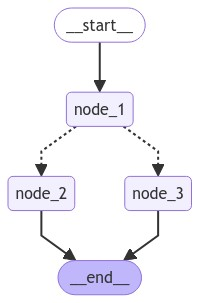

In [ ]:
# Build graph
builder = StateGraph(PydanticState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
graph.invoke(PydanticState(name="Lance", mood="sad"))

---Node 1---
---Node 3---


{'name': 'Lance is ... ', 'mood': 'sad'}